<a href="https://colab.research.google.com/github/Deepak-Mewada/NeuralDecoder/blob/main/BrainDecoder/Basics/Self_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install braindecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 8.2 MB/s eta 0:00:00


In [ ]:
from braindecode.datasets.sleep_physionet import SleepPhysionet
random_state = 87
n_jobs = 1
dataset = SleepPhysionet(
    subject_ids=[0, 1, 2], recording_ids=[1], crop_wake_mins=30)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [ ]:
from braindecode.preprocessing.preprocess import preprocess, Preprocessor
from numpy import multiply

high_cut_hz = 30
factor = 1e6

preprocessors = [
    Preprocessor(lambda data: multiply(data, factor)),
    Preprocessor('filter', l_freq=None, h_freq=high_cut_hz, n_jobs=n_jobs)
]


preprocess(dataset, preprocessors)

Reading 0 ... 2508000  =      0.000 ... 25080.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 s)



/usr/local/lib/python3.10/dist-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Reading 0 ... 3261000  =      0.000 ... 32610.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 s)

Reading 0 ... 3060000  =      0.000 ... 30600.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 s

In [ ]:
from braindecode.preprocessing.windowers import create_windows_from_events

window_size_s = 30
sfreq = 100
window_size_samples = window_size_s * sfreq

mapping = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

windows_dataset = create_windows_from_events(
    dataset, trial_start_offset_samples=0, trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples, preload=True, mapping=mapping)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


In [ ]:
from sklearn.preprocessing import scale as standard_scale

preprocess(windows_dataset, [Preprocessor(standard_scale, channel_wise=True)])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from braindecode.datasets import BaseConcatDataset

subjects = np.unique(windows_dataset.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)


class RelativePositioningDataset(BaseConcatDataset):

    def __init__(self, list_of_ds):
        super().__init__(list_of_ds)
        self.return_pair = True

    def __getitem__(self, index):
        if self.return_pair:
            ind1, ind2, y = index
            return (super().__getitem__(ind1)[0],
                    super().__getitem__(ind2)[0]), y
        else:
            return super().__getitem__(index)


    def return_pair(self):
        return self._return_pair


    def return_pair(self, value):
        self._return_pair = value


split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = RelativePositioningDataset(
        [ds for ds in windows_dataset.datasets
         if ds.description['subject'] in values])

In [ ]:
from braindecode.samplers import RelativePositioningSampler

tau_pos, tau_neg = int(sfreq * 60), int(sfreq * 15 * 60)
n_examples_train = 250 * len(splitted['train'].datasets)
n_examples_valid = 250 * len(splitted['valid'].datasets)
n_examples_test = 250 * len(splitted['test'].datasets)

train_sampler = RelativePositioningSampler(
    splitted['train'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_train, same_rec_neg=True, random_state=random_state)
valid_sampler = RelativePositioningSampler(
    splitted['valid'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_valid, same_rec_neg=True,
    random_state=random_state).presample()
test_sampler = RelativePositioningSampler(
    splitted['test'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_test, same_rec_neg=True,
    random_state=random_state).presample()

In [ ]:
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True

set_random_seeds(seed=random_state, cuda=device == 'cuda')

n_channels, input_size_samples = windows_dataset[0][0].shape
emb_size = 100
classes = list(range(5))

emb = SleepStagerChambon2018(
    n_channels,
    sfreq,
    n_outputs=emb_size,
    n_conv_chs=16,
    n_times=input_size_samples,
    dropout=0,
    apply_batch_norm=True,
)


class ContrastiveNet(nn.Module):

    def __init__(self, emb, emb_size, dropout=0.5):
        super().__init__()
        self.emb = emb
        self.clf = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(emb_size, 1)
        )

    def forward(self, x):
        x1, x2 = x
        z1, z2 = self.emb(x1), self.emb(x2)
        return self.clf(torch.abs(z1 - z2)).flatten()


model = ContrastiveNet(emb, emb_size).to(device)


In [ ]:
import os

from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint, EarlyStopping, EpochScoring
from braindecode import EEGClassifier

lr = 5e-3
batch_size = 128
n_epochs = 25
num_workers = 0 if n_jobs <= 1 else n_jobs

cp = Checkpoint(dirname='', f_criterion=None, f_optimizer=None, f_history=None)
early_stopping = EarlyStopping(patience=10)
train_acc = EpochScoring(
    scoring='accuracy', on_train=True, name='train_acc', lower_is_better=False)

callbacks = [
    ('cp', cp),
    ('patience', early_stopping),
    ('train_acc', train_acc),
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    max_epochs=n_epochs,
    iterator_train__shuffle=False,
    iterator_train__sampler=train_sampler,
    iterator_valid__sampler=valid_sampler,
    iterator_train__num_workers=num_workers,
    iterator_valid__num_workers=num_workers,
    train_split=predefined_split(splitted['valid']),
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device,
    classes=classes,
)

clf.fit(splitted['train'], y=None)
clf.load_params(checkpoint=cp)

os.remove('./params.pt')

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.5234        0.7013       0.6680        0.6320     +  2.6237
      2       0.5938        0.7149       0.4880        0.8357        2.1794
      3       0.4922        1.0040       0.6440        0.6172     +  2.1457
      4       0.5234        0.7031       0.6120        0.5988     +  2.1490
      5       0.5391        0.6752       0.5920        0.6210        2.6379
      6       0.6719        0.6236       0.5880        0.6255        2.1326
      7       0.6641        0.6316       0.6200        0.6105        2.1118
      8       0.6562        0.6254       0.6440        0.5928     +  2.0472
      9       0.6484        0.6224       0.6720        0.5769     +  2.0425
     10       0.6562        0.6158       0.6800        0.5730     +  2.5058
     11       0.6172        0.6312       0.7040        0.5776        2.2219
     12     

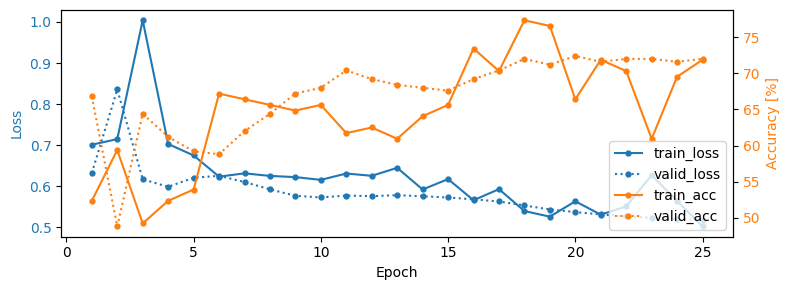

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(clf.history.to_list())

df['train_acc'] *= 100
df['valid_acc'] *= 100

ys1 = ['train_loss', 'valid_loss']
ys2 = ['train_acc', 'valid_acc']
styles = ['-', ':']
markers = ['.', '.']

fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()
for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax1.plot(df['epoch'], df[y1], ls=style, marker=marker, ms=7,
             c='tab:blue', label=y1)
    ax2.plot(df['epoch'], df[y2], ls=style, marker=marker, ms=7,
             c='tab:orange', label=y2)

ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylabel('Loss', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_ylabel('Accuracy [%]', color='tab:orange')
ax1.set_xlabel('Epoch')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2)

plt.tight_layout()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

clf.iterator_valid__sampler = test_sampler
y_pred = clf.forward(splitted['test'], training=False) > 0
y_true = [y for _, _, y in test_sampler]

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[87 34]
 [40 89]]
              precision    recall  f1-score   support

         0.0       0.69      0.72      0.70       121
         1.0       0.72      0.69      0.71       129

    accuracy                           0.70       250
   macro avg       0.70      0.70      0.70       250
weighted avg       0.70      0.70      0.70       250



In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


data = dict()
for name, split in splitted.items():
    split.return_pair = False
    loader = DataLoader(split, batch_size=batch_size, num_workers=num_workers)
    with torch.no_grad():
        feats = [emb(batch_x.to(device)).cpu().numpy()
                 for batch_x, _, _ in loader]
    data[name] = (np.concatenate(feats), split.get_metadata()['target'].values)


log_reg = LogisticRegression(
    penalty='l2', C=1.0, class_weight='balanced', solver='lbfgs',
    multi_class='multinomial', random_state=random_state)
clf_pipe = make_pipeline(StandardScaler(), log_reg)


clf_pipe.fit(*data['train'])
train_y_pred = clf_pipe.predict(data['train'][0])
valid_y_pred = clf_pipe.predict(data['valid'][0])
test_y_pred = clf_pipe.predict(data['test'][0])

train_bal_acc = balanced_accuracy_score(data['train'][1], train_y_pred)
valid_bal_acc = balanced_accuracy_score(data['valid'][1], valid_y_pred)
test_bal_acc = balanced_accuracy_score(data['test'][1], test_y_pred)

print('Sleep staging performance with logistic regression:')
print(f'Train bal acc: {train_bal_acc:0.4f}')
print(f'Valid bal acc: {valid_bal_acc:0.4f}')
print(f'Test bal acc: {test_bal_acc:0.4f}')

print('Results on test set:')
print(confusion_matrix(data['test'][1], test_y_pred))
print(classification_report(data['test'][1], test_y_pred))

Sleep staging performance with logistic regression:
Train bal acc: 0.8869
Valid bal acc: 0.5354
Test bal acc: 0.6434
Results on test set:
[[107  24   4   5   2]
 [  9  75   9   2  14]
 [ 43  47 402   2  68]
 [  0   0  53  52   0]
 [  0  57  17   0  96]]
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       142
           1       0.37      0.69      0.48       109
           2       0.83      0.72      0.77       562
           3       0.85      0.50      0.63       105
           4       0.53      0.56      0.55       170

    accuracy                           0.67      1088
   macro avg       0.65      0.64      0.63      1088
weighted avg       0.72      0.67      0.68      1088



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<ipython-input-18-c8a4573ca133>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', 5)(range(5))


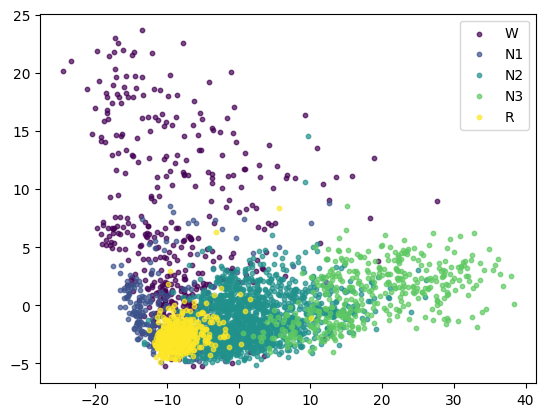

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import cm

X = np.concatenate([v[0] for k, v in data.items()])
y = np.concatenate([v[1] for k, v in data.items()])

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig, ax = plt.subplots()
colors = cm.get_cmap('viridis', 5)(range(5))
for i, stage in enumerate(['W', 'N1', 'N2', 'N3', 'R']):
    mask = y == i
    ax.scatter(components[mask, 0], components[mask, 1], s=10, alpha=0.7,
               color=colors[i], label=stage)
ax.legend()